In [1]:
%pylab inline
# load the path image and the path data
from PIL import Image
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from smalllib import of, ff

In [3]:
# the input files
path_image = "../images/path.png"
gpkg_path = "../images/path.gpkg"

In [4]:
# load everything
im = Image.open(path_image)
ref_frame = gpd.read_file(gpkg_path, layer="reference_frame")
ref_frame.crs = None # force to none, just for clarity, we might have digitized in a valid crs but we are not interested

In [5]:
ref_frame # this is the table of digitized points

,x,y,geometry
0,0.0,0.0,POINT (421.429 -276.425)
1,0.0,-40.0,POINT (421.495 -549.363)
2,-50.0,0.0,POINT (72.020 -276.412)
3,-40.0,-40.0,POINT (142.527 -549.680)
4,20.0,20.0,POINT (560.556 -140.517)
5,-20.0,20.0,POINT (281.457 -140.477)
6,20.0,-30.0,POINT (560.464 -481.534)


The table above is used to reconstruct the transform from pixel-coordinates to metric coordinates, which are needed for digitizing the dataset of the path

In [6]:
px_coords = np.array([np.array(p.coords)[0] for p in ref_frame.geometry]) # extract the pixel coordinates
px_coords

array([[ 421.42864359, -276.42489224],
       [ 421.49461207, -549.36288389],
       [  72.01998922, -276.41169855],
       [ 142.52710129, -549.6795326 ],
       [ 560.55616918, -140.5166285 ],
       [ 281.45672144, -140.47704741],
       [ 560.46381331, -481.53409213]])

In [7]:
m_coords = np.array(ref_frame[["x", "y"]]) # extract the coordinates in meters for the same points
m_coords

array([[  0.,   0.],
       [  0., -40.],
       [-50.,   0.],
       [-40., -40.],
       [ 20.,  20.],
       [-20.,  20.],
       [ 20., -30.]])

we determine the transform between the two, we know the two set of points do correspont to each other and there must be a transform between the two
we use an affine transform for this... via affine6p (or nudged library if you prefer)

In [8]:
#pip install affine6p --user if not installed already

In [9]:
import affine6p
# using a complete affine transform is a little overkill in our case, but in the general situation migh be desirable, especially when workin on scanned imagery

In [10]:
T = affine6p.estimate(px_coords.tolist(), m_coords.tolist())
err = affine6p.estimate_error(T, px_coords.tolist(), m_coords.tolist()) # mean squared distance
np.sqrt(err) # around 20 cm average error due to digitalization

0.2119157447665207

we got a very low error, good!

we have our transform, now we work with the picture


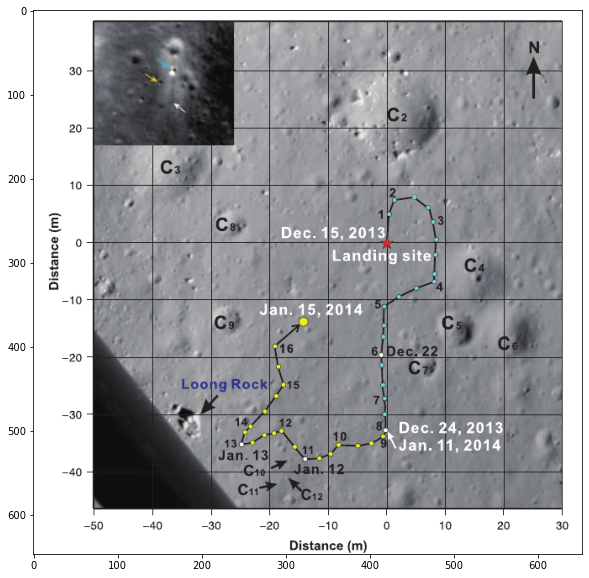

In [11]:
figure(figsize=(10,10)) # fast inspection
imshow(im)

Now we want to save the raster as a geotiff file using rasterio

We define the absolute position of the landing site in an absolute reference frame. These values are obtanied from QGIS and picking the landing site onto the orthoimage (see companion dataset)

Note that we do not actually know the crs of the map we imported, but we know is a metric framework. We will try to use the same crs with eqc projection as the orthoimages and the DEM from LROC NAC. For such small distances using the wrong projection will not be noticeable

In [12]:
coords_start = np.array([3500707.20,1337897.55]) # landing site coords in the ref frame below
crs = "+proj=eqc +lat_ts=44 +lat_0=0 +lon_0=180 +x_0=0 +y_0=0 +R=1737400 +units=m +no_defs +type=crs" # the crs of the coords above

np.savetxt(of("landing_coordinates.txt"), coords_start) # we also save them for future use


# T provide the transform from pixel to meter coordinates in a reference frame with the origin in the top left corner with y-axis upward
# we need to alter the transform to a different reference with y downward: for this reason we chenge the sign of mt[1,1]
mt = np.array(T.get_matrix())[:2,:]
mt[1,1] = - mt[1,1]
mt[:,2] += coords_start # add the global shift

import rasterio
at = rasterio.transform.Affine(*mt.ravel()) # fnally recreate a rasterio-compatible affine transform

In [13]:
im_asarr = np.array(im) # to a numpy array
im_asarr = np.moveaxis(im_asarr, 2, 0) # move the 3d axis (the one with colors) to the first position, rasterio is expecting the bands (r,g,b) to be the first-axis dimension

In [14]:
# save it, finally
import os
with rasterio.open(
    of('path_georef.tif'),
    'w',
    photometric="RGB",
    driver='GTiff',
    height=im_asarr.shape[1],
    width=im_asarr.shape[2],
    count=4,
    dtype=im_asarr.dtype,
    crs=crs,
    transform=at # here we plug the affine transform computed above
)as dst:
    dst.write(im_asarr, [1,2,3,4])



Now the raster is georeferenced, you can open it up in qgis and verify it.

# Now the path-data

In [15]:
path = gpd.read_file(gpkg_path, layer="path") # load the data for the path
path_px_coords = np.array([np.array(p.coords[0]) for p in path.geometry]) # as a pure numpy array

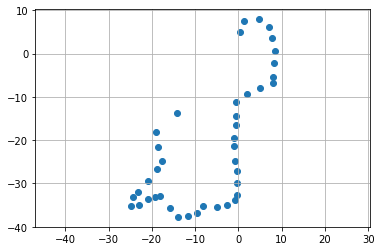

In [16]:
path_m_coords = np.array(T.transform(path_px_coords.tolist())) # apply transform
scatter(*path_m_coords.T) # and plot
axis("equal")
grid()



We correctly digitized the points of the path in meters

In [17]:
from shapely.geometry import Point, LineString
asgeom_m = [Point(p) for p in path_m_coords]


# when digitizing we did not digitize the landing point site (station 0), we jsut add i at Point(0,0)
numbers = list(path.progressive_number)
numbers.insert(0, np.nan)
asgeom_m.insert(0, Point(0,0))

# recreate the dataframe
path = gpd.GeoDataFrame(geometry=asgeom_m)
path["progressive_number"] = numbers

we can now plot the data and save it

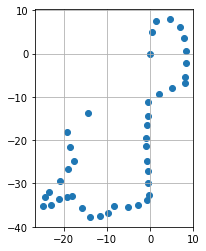

In [18]:
path.plot()
grid()

In [19]:
newgeom = path.translate(*coords_start) # we add the coordinates of the landing site to match the crs

path_t = path.copy() # copy
path_t.geometry = newgeom # set the new geometry
path.crs = crs # and the crs

In [20]:
path_t.to_file(of("path.gpkg"), driver="GPKG")